In [19]:
%matplotlib inline

Example of processing steps within single-subject:

The following steps create trial-unique beta maps from the CIMAQ fMRI data (memory: image encoding) to be fed to a nilearn classifier.
Inputs:
    - task (event) files generated from raw eprime outputs and organized into .tsv file by subject_behavdata.py script
    - confound (motion, etc) files generated from Niak preprocessing
    pipeline (confounds.tsv) 
    - preprocessed Niak data 

Note: a separate model is built for each trial, with the trial of interest modelled as a separate condition, and all the other trials modelled as either Encoding or Control, to reduce the number of parameters in each model (to avoid having more parameters than TRs) 

In [20]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import nilearn
import nistats
import scipy
import nibabel

from numpy import nan as NaN
from matplotlib import pyplot as plt
from nistats.reporting import plot_design_matrix
from nistats.first_level_model import FirstLevelModel
from nistats.design_matrix import make_first_level_design_matrix
from nilearn import image, plotting
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show

#libraries need to be installed in conda environment with pip install

Step 1: Load confound parameters outputed from NIAK pipeline (slow signal drift, motion parameters, mean white matter signal intensity and mean ventricle signal intensity)

**Note: The full NIAK preprocessing pipeline scrubs (regresses out) motion outlier frames, which may not be compatible with other software like Nilearn or Nistats.
Intermediate data from the preprocessing pipeline should be used that have been slice-timed, co-registered and resampled (motion-corrected).  

These data are found under the **resample** directory (not fMRI), in .nii format, with accompanying _extra.mat and confounds.tsv.gz files. 
These data have undergone **no smoothing**, and confounds have not been regressed out. 

Use gunzip *gz command to unzip .tsv files inside motion file directory

**Update: the nistats first-level model can also model some of the slow drift and noise parameters (not used here)
Here, we use all the confunds in counfounds.tsv, so we don't model slow drift, etc in the first-level model (to reduce the number of parameters). 

In [21]:
id = '122922' #this subject has 310 frames, few scrubbed frames, good data
#good balance of missed (23 trials), wrong source (30 trials) and correct source (25 trials)
#id = '763590' #test w 288 frames

#specify path to directory with confound files 
motion_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/MotionFiles/motion_resample/fromNIAK'

subject_motion = glob.glob(os.path.join(motion_dir, 'fmri_sub'+id+'*confounds.tsv'))[0]

#load counfounds file as pandas dataframe 
confounds = pd.read_csv(subject_motion, sep='\t')

#create "short" counfounds dataframe with only a subset of confounds
#these counfounds are to be used if slow drift, etc is modelled in nistats rather than niak
short_counfounds = confounds.copy(deep = True)

#select which columsn from NIAK counfounds.tsv file to include in model (in case  
#slow-drift and other junk parameters are modellled within Nistats instead of NIAK)
colsKeep = ['motion_tx', 'motion_ty', 'motion_tz', 'motion_rx', 
            'motion_ry', 'motion_rz', 'scrub', 'wm_avg', 'vent_avg']

cols = confounds.columns

#remove columns not in list of colums to keep (colsKeep)
for i in cols:
    if (i in colsKeep)==False:
        short_counfounds.drop([i], axis=1, inplace=True)    

#scan duration, in seconds : number of fMRI frames (~310), times TR = 2.5s
scanDur = confounds.shape[0]*2.5

print(scanDur)

775.0


Step 2: create events variable, and events.tsv file from the 'sub-*_ses-4_task-memory_events.tsv' task file outputed by the subject_behavdata.py script using Nistats

Number of rows = number of trials (first-level model will use onset times to match conditions (trials) with fMRI frames).

Details:
https://nistats.github.io/auto_examples/04_low_level_functions/write_events_file.html#sphx-glr-auto-examples-04-low-level-functions-write-events-file-py

Each encoding trial is modelled as a different condition (trial_idx) so that it is modelled separately when creating the design matrix (trial has its own row; rest of columns = other trials (separately or modelled together), and confound regressors).

**Note: Some scans were cut short, meaning that the last few trials do not have associated brain activation frames, and they need to be left out of the analysis; 310 frames = full scan, 288 frames = incomplete (~15 participants).
"unscanned" trials need to be excluded from the model (about ~2-4 trials missing).
288*2.5 = 720s. 
Trial #115 (out of 117) offset time ~ 710s
Trial #116 (out of 117) onset ~ 723s

In [22]:
#specify path to directory with task files (eventually on Stark)
task_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/TaskFiles/Processed'

#specify output directory
outTask_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Events'

subject_task = glob.glob(os.path.join(task_dir, 'sub-'+id+'*tsv'))[0]

#load subject's task data as pandas dataframe 
s_task = pd.read_csv(subject_task, sep='\t')

#add columns to DataFrame
numCol = s_task.shape[1] 
insertCol = [3, 4, numCol+2, numCol+3]
colNames = ['trial_idx', 'trial_label', 'unscanned', 'enctrial_type']
colVals = [-1, 'None', 0, 'TBD']

for i in range(0, len(colNames)):
    s_task.insert(loc=insertCol[i], column=colNames[i], value=colVals[i], allow_duplicates=True)

#Fill up columns with values
#Model each encoding trial as a separate condition
count = 1
for i in s_task[s_task['trial_type']=='Enc'].index:
    s_task.loc[i, 'trial_idx'] = count #each trial modelled as different condition
    s_task.loc[i, 'trial_label'] = 'Enc'+str(count)
    if s_task.loc[i, 'position_accuracy'] == 0:
        s_task.loc[i, 'enctrial_type']='missed'
    elif s_task.loc[i, 'position_accuracy'] == 1:
        s_task.loc[i, 'enctrial_type']='wrongsource'
    elif s_task.loc[i, 'position_accuracy'] == 2:
        s_task.loc[i, 'enctrial_type']='correctsource'
    count = count + 1

#78 if full scan
numEncTrials = count - 1

#Model all control task trials as from same condition
#modelled but not further analyzed
for j in s_task[s_task['trial_type']=='CTL'].index:
    s_task.loc[j, 'trial_idx'] = count
    s_task.loc[j, 'trial_label'] = 'Control'
    
#flag trials for which no brain data was acquired
for k in s_task[s_task['offset']>scanDur].index:
    s_task.loc[k, 'unscanned']=1
    
#Export Dataframe to events.tsv file    
s_task.to_csv(outTask_dir+'/sub-'+id+'_events.tsv',
sep='\t', header=True, index=False)
    
#remove trials for which there is no fMRI data collected
s_task = s_task[s_task['unscanned']==0]

#from s_task dataframe, create events dataframe to input nistats first-level model 
#(one model for all trials).
#3 columns = onset, duration, trial_type (each encoding trial = modelled as its own condition)
#1-78 = encoding trials in temporal order, 79 = control trials (modelled together as single condition)
SingleModel_events = s_task.iloc[:, 1:4]
SingleModel_events.rename(columns={'trial_idx':'trial_type'}, inplace=True)

#create events dataframe to input several separate models 
#(one model per trial, for both conditions)
#1-78 = encoding trials in temporal order; 79+ = control trials in temporal order
for m in s_task[s_task['trial_type']=='CTL'].index:
    s_task.loc[m, 'trial_idx'] = count
    count = count+1

#39 trials if full scan
numCTLtrials = count - (1+numEncTrials)

MultiModel_events = s_task.iloc[:, 1:4]
MultiModel_events.rename(columns={'trial_idx':'trial_type'}, inplace=True)

print(SingleModel_events.shape)
print(SingleModel_events.iloc[0:15, :])

print(MultiModel_events.shape)
print(MultiModel_events.iloc[0:15, :])


(117, 3)
     onset  duration  trial_type
0   25.027     3.009           1
1   28.537     3.009          79
2   32.048     3.009           2
3   39.553     3.009           3
4   44.552     3.009          79
5   51.054     3.009          79
6   55.551     3.009           4
7   61.051     3.009           5
8   65.063     3.009          79
9   71.064     3.009           6
10  78.068     3.009          79
11  81.579     3.008           7
12  87.078     3.009          79
13  92.578     3.009          79
14  99.081     3.009           8
(117, 3)
     onset  duration  trial_type
0   25.027     3.009           1
1   28.537     3.009          79
2   32.048     3.009           2
3   39.553     3.009           3
4   44.552     3.009          80
5   51.054     3.009          81
6   55.551     3.009           4
7   61.051     3.009           5
8   65.063     3.009          82
9   71.064     3.009           6
10  78.068     3.009          83
11  81.579     3.008           7
12  87.078     3.009     

**Step3 : Implement first-level model (implements regression in nistats), generate contrasts and output maps of beta values (parameter estimators; one map of betas per trial).

**About first-level model:

Note 1: nistats.first_level_model provides an interface to use the glm implemented in nistats.regression

Note 2: each encoding trial is modelled as a separate condition to obtain separate maps of beta values (output type for betas: **effect sizes** (Nistats name), aka parameter estimates)

**UPDATE: trying to either (Version A) have each trial modelled within the same large model as separate conditions (parameter); or have a separate model created for each trial (Version B), 
where trial of interest is a condition, and other trials are modelled together. 
Note that Version A has a much higher number of parameters per model (although inferior to number of frames)

Note 3: the first_level_model can either be given a pre-defined **design matrix** (built from the events and confounds files as a separate step) as a parameter, or the **events and confounds** files can be passed directly as parameters (skipping the need to create a design matrix in a separate step). In the latter case, the model will generate and output the design matrix.  

As a parameter to the first-level-model, the design matrix takes precedence over the events and confounds parameters.

Nistats link on design matrices:
https://nistats.github.io/auto_examples/04_low_level_functions/plot_design_matrix.html

https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html

Example where the design matrix is created directly within the first level model interface by inputing events and confounds files directly as parameters (I'm not doing that here): https://nistats.github.io/auto_examples/01_tutorials/plot_first_level_model_details.html#running-a-basic-model

CHOSEN: 2-step method. Create design matrix directly from events file and confounds outputed from NIAK (resample directory), then generate and fit first-level-model

**About contrasts and maps of beta values (parameter estimators):

When each trial is modeled as a separate condition, it is represented as its own column in the design matrix. 

To access the estimated coefficients (betas of the GLM model), we need to specify "canonical contrasts" (one per trial) that isolate design matrix columns (each contrast has a single 1 in its corresponding colum, and 0s for all the other columns).

Sources of info: how to extract beta maps in nistats (instructions are a bit obscure)
https://15-35545854-gh.circle-artifacts.com/0/home/ubuntu/nistats/doc/_build/html/auto_examples/plot_spm_auditory.html
https://github.com/poldracklab/fitlins/pull/48
https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html#nistats.first_level_model.FirstLevelModel


**Step 3, Version A (one large model): First create a design matrix from the events and confounds dataframes, and then input it to the first level model as a parameter** 


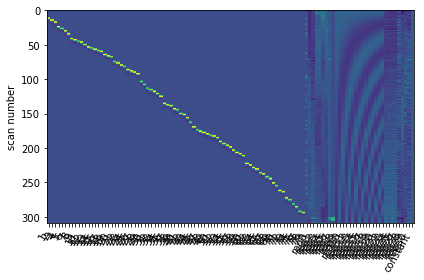

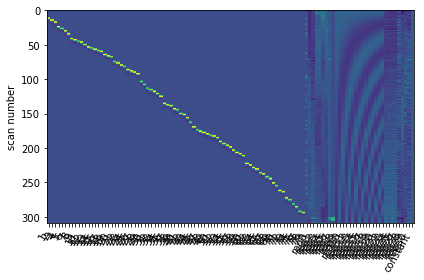

betas_sub122922_Trial1.nii
betas_sub122922_Trial2.nii
betas_sub122922_Trial3.nii
betas_sub122922_Trial4.nii
betas_sub122922_Trial5.nii
betas_sub122922_Trial6.nii
betas_sub122922_Trial7.nii
betas_sub122922_Trial8.nii
betas_sub122922_Trial9.nii
betas_sub122922_Trial10.nii
betas_sub122922_Trial11.nii
betas_sub122922_Trial12.nii
betas_sub122922_Trial13.nii
betas_sub122922_Trial14.nii
betas_sub122922_Trial15.nii
betas_sub122922_Trial16.nii
betas_sub122922_Trial17.nii
betas_sub122922_Trial18.nii
betas_sub122922_Trial19.nii
betas_sub122922_Trial20.nii
betas_sub122922_Trial21.nii
betas_sub122922_Trial22.nii
betas_sub122922_Trial23.nii
betas_sub122922_Trial24.nii
betas_sub122922_Trial25.nii
betas_sub122922_Trial26.nii
betas_sub122922_Trial27.nii
betas_sub122922_Trial28.nii
betas_sub122922_Trial29.nii
betas_sub122922_Trial30.nii
betas_sub122922_Trial31.nii
betas_sub122922_Trial32.nii
betas_sub122922_Trial33.nii
betas_sub122922_Trial34.nii
betas_sub122922_Trial35.nii
betas_sub122922_Trial36.nii
b

In [23]:
#where save beta maps (make subject subdirectories?)
outBeta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/SingleModel'

#Define parameters related to image acquisition
tr = 2.5 #repetition time in seconds
n_scans = confounds.shape[0] #number of frames
frame_times = np.arange(n_scans)*tr # corresponding frame times for each scan

hrf_model = 'spm' #alternatives: 'glover', or 'spm + derivative'

#Create design matrix
#slow drift modelled with NIAK preprocessing pipeline
design = make_first_level_design_matrix(frame_times, events=SingleModel_events, 
                                        drift_model=None, add_regs=confounds, 
                                        hrf_model=hrf_model)

#Other example: modeling drift w polynomial function
#design = make_first_level_design_matrix(frame_times = frame_times, events,
#drift_model='polynomial', drift_order=3, add_regs=confounds,
#add_reg_names=sconf.columns, hrf_model=hrf_model)

plot_design_matrix(design)
plt.show()

##specify: path to preprocessed fMRI .nii file (gunzip it first!)
fmri_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/fMRI'
fmri_imgNS = glob.glob(os.path.join(fmri_dir, 'fmri_sub'+id+'*nii'))[0]

#8mm smoothing since using unsmoothed preprocessed data (NIAK output: resample)
fmri_img = image.smooth_img(fmri_imgNS, 8)

#create first-level model from design matrix
#??use noise model if inputing design matrix directly?
s_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
hrf_model = hrf_model)

#fit model with desigm matrix
s_model = s_model.fit(fmri_img, design_matrices = design)
#fit model with events and confounds data
#s_model = s_model.fit(fmri_img, events=events, confounds = confounds)

model_designMatrix = s_model.design_matrices_[0]
    
plot_design_matrix(model_designMatrix)
plt.show()

#numpy eye: return a 2-D array w ones on diagonal and zeroes elsewhere
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html
contrast_matrix = np.eye(model_designMatrix.shape[1]) #dimensions = num columns

#print(model_designMatrix.columns)

#Dictionnary of constrasts:
#Each contrast is a (key, name) pair;
#key = name of column from model_designMatrix
#value = a contrast (vector) with weight=1 for the model_designMatrix column of interest, 
#and 0s elsewhere for the other columns.
#Note that contrasts are generated for the first 78 columns, 
#each of which corresponds to an encoding trial
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(model_designMatrix.columns[0:numEncTrials])])

#Compile list of beta maps and their trial number, to be sorted by order of trial
enc_betas_filelist = []

#Compute the per-contrast beta maps,
#export b_map .nii image in output directory
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    b_map = s_model.compute_contrast(
        contrast_val, output_type='effect_size') #for voxels values = betas
    b_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_Trial'+str(contrast_id)+'.nii')
    nibabel.save(b_map, b_name)
    print(os.path.basename(b_name))
    enc_betas_filelist.append(b_name)

allenc_betas = nibabel.funcs.concat_images(images=enc_betas_filelist, check_affines=True, axis=None)

print(allenc_betas.shape)
nibabel.save(allenc_betas, os.path.join(outBeta_dir, 'concat_enc_betas_sub'+str(id)+'.nii'))


**Version B: A separate model created for each trial.
Trial of interest modelled as its own condition, and other trials are modelled as two conditions: control, and encoding (excluding trial of interest)

Note 1: contrasts are also derived for the control trials (as a proof of principle, we can check if we can classify encoding vs control condition, at the very least)

Note 2: added a basic contrast between the two conditions, encoding vs control (all trials)

In [24]:
#where save beta maps (make subject subdirectories?)
outBeta_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Nistats/Betas/122922/OneModelPerTrial'

#117 trials if full scan (no missing frames)
numTrials = MultiModel_events.shape[0]

#Compile list of beta maps and their trial number, to be sorted by order of trial
all_betas_filelist = []

#Create a design matrix, first level model and beta map for each encoding and control trial 
for i in range(0, numTrials):

    #copy MultiModel_events dataframe to keep the original intact
    events = MultiModel_events.copy(deep = True)

    tnum = events.iloc[i, 2]
    
    #Determine label for condition of current trial (encoding or control)
    if tnum < (numEncTrials+1):
        currentCondi = 'Enc'
    else:
        currentCondi = 'CTL'
        
    #modify trial_type column to model only the trial of interest (tnum)
    for j in events.index:
        if events.loc[j, 'trial_type'] == tnum:
            events.loc[j, 'trial_type']= currentCondi+str(tnum)
        elif events.loc[j, 'trial_type'] < (numEncTrials+1):
            events.loc[j, 'trial_type']='X_Enc' #X for condition alphabetical order
        else:
            events.loc[j, 'trial_type']='X_CTL' #X for alphabetical order
        #figure out: what determines the order of columns in design matrix?    
            
    #create the design matrix
    design = make_first_level_design_matrix(frame_times, events=events,
                                            drift_model=None, add_regs=confounds, 
                                            hrf_model=hrf_model)

    s_model = FirstLevelModel(t_r=tr, drift_model = None, standardize = True, noise_model='ar1',
    hrf_model = hrf_model)
    #Should data be standardized?

    #fit model with desigm matrix
    s_model = s_model.fit(fmri_img, design_matrices = design)
    
    design_matrix = s_model.design_matrices_[0]
    
    #sanity check: print design matrices and corresponding parameter labels
    #plot outputed design matrix for visualization
    #print(currentCondi+str(tnum), ' ', design_matrix.columns[0])
    #plot_design_matrix(design_matrix)
    #plt.show()

    #Contrast vector: 1 in design matrix column that corresponds to trial of interest, 0s elsewhere
    contrast_vec = np.repeat(0, design_matrix.shape[1])
    contrast_vec[0] = 1

    if tnum == 32:
        contrast_EncMinusCTL = np.repeat(0, design_matrix.shape[1])
        contrast_EncMinusCTL[1] = -1 #control condition
        contrast_EncMinusCTL[2] = 1 #encoding condition
        print(contrast_EncMinusCTL)
        b_tasks = s_model.compute_contrast(contrast_EncMinusCTL, output_type='effect_size') #for betas
        t_tasks = s_model.compute_contrast(contrast_EncMinusCTL, stat_type='t', output_type='stat') #for tscores
        nibabel.save(b_tasks, os.path.join(outBeta_dir, 'EncMinCTL_betas_sub'+str(id)+'.nii'))
        nibabel.save(t_tasks, os.path.join(outBeta_dir, 'EncMinCTL_tscores_sub'+str(id)+'.nii'))
        
    #compute the contrast's beta maps with the model.compute_contrast() method,
    #based on contrast provided. 
    #https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html
    b_map = s_model.compute_contrast(contrast_vec, output_type='effect_size') #for betas
    b_name = os.path.join(outBeta_dir, 'betas_sub'+str(id)+'_Trial'+str(i+1)+'_'+currentCondi+str(tnum)+'.nii')
    #export b_map .nii image in output directory
    nibabel.save(b_map, b_name)
    print(os.path.basename(b_name))
    all_betas_filelist.append(b_name)
    
alltrials_betas = nibabel.funcs.concat_images(images=all_betas_filelist, check_affines=True, axis=None)
print(alltrials_betas.shape)
nibabel.save(alltrials_betas, os.path.join(outBeta_dir, 'concat_all_betas_sub'+str(id)+'.nii'))
    

betas_sub122922_Trial1_Enc1.nii
betas_sub122922_Trial2_CTL79.nii
betas_sub122922_Trial3_Enc2.nii
betas_sub122922_Trial4_Enc3.nii
betas_sub122922_Trial5_CTL80.nii
betas_sub122922_Trial6_CTL81.nii
betas_sub122922_Trial7_Enc4.nii
betas_sub122922_Trial8_Enc5.nii
betas_sub122922_Trial9_CTL82.nii
betas_sub122922_Trial10_Enc6.nii
betas_sub122922_Trial11_CTL83.nii
betas_sub122922_Trial12_Enc7.nii
betas_sub122922_Trial13_CTL84.nii
betas_sub122922_Trial14_CTL85.nii
betas_sub122922_Trial15_Enc8.nii
betas_sub122922_Trial16_Enc9.nii
betas_sub122922_Trial17_Enc10.nii
betas_sub122922_Trial18_Enc11.nii
betas_sub122922_Trial19_Enc12.nii
betas_sub122922_Trial20_Enc13.nii
betas_sub122922_Trial21_Enc14.nii
betas_sub122922_Trial22_Enc15.nii
betas_sub122922_Trial23_Enc16.nii
betas_sub122922_Trial24_Enc17.nii
betas_sub122922_Trial25_CTL86.nii
betas_sub122922_Trial26_Enc18.nii
betas_sub122922_Trial27_Enc19.nii
betas_sub122922_Trial28_Enc20.nii
betas_sub122922_Trial29_CTL87.nii
betas_sub122922_Trial30_Enc21.ni

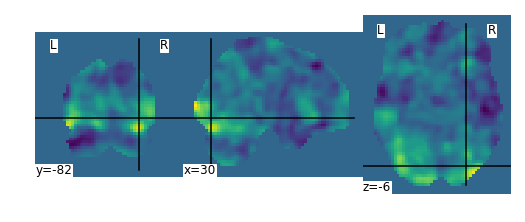

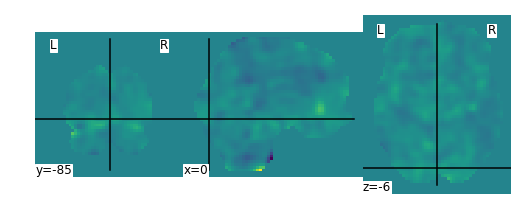

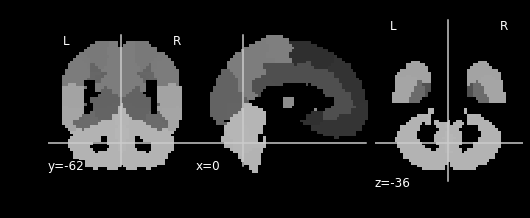

In [32]:
#plotting brain images in nilearn:
#http://nilearn.github.io/plotting/index.html

#Visualize beta_map
map = glob.glob(os.path.join(outBeta_dir, 'betas_sub'+str(id)+'*_Enc32.nii'))[0]
taskComp = os.path.join(outBeta_dir, 'EncMinCTL_tscores_sub'+str(id)+'.nii')

#link to template images:
temp_dir = '/Users/mombot/Documents/Simexp/CIMAQ/Data/Templates'
temp_img = os.path.join(temp_dir, 'template_aal.nii')

#plot_epi(map)
plot_img(taskComp)
plot_img(map)
plot_anat(temp_img)
show()